In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from matplotlib.ticker import FormatStrFormatter
import re
import os
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import math
from matplotlib.lines import Line2D

txt_files_folder = '/hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/'
csv_output_folder = '/hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files'

if not os.path.exists(csv_output_folder):
    os.makedirs(csv_output_folder)
    print(f"Created output folder: {csv_output_folder}")

columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', 'deldot', '']

for file_name in os.listdir(txt_files_folder):
    if file_name.endswith('.txt'):
        file_path = os.path.join(txt_files_folder, file_name)
        start_marker = "$$SOE"
        end_marker = "$$EOE"
        data_lines = []
        try:
            with open(file_path, 'r') as file:
                is_data = False
                for line in file:
                    if start_marker in line:
                        is_data = True
                    elif end_marker in line:
                        is_data = False
                    elif is_data:
                        data_lines.append(line.strip())
            
            data = [line.split(",") for line in data_lines]
            
            max_columns = max(len(row) for row in data)
            data = [row + [''] * (max_columns - len(row)) for row in data]
            
            df = pd.DataFrame(data, columns=columns[:max_columns])
            
            base_name = os.path.splitext(file_name)[0]
            csv_file_path = os.path.join(csv_output_folder, f'{base_name}.csv')
            
            df.to_csv(csv_file_path, index=False)
            print(f"CSV file saved: {csv_file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2020 UF7.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/4953.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2022 QV1.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2024 ON.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2024 RN45.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2022 PH1.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2022 YK6.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2024 SJ.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files/2024 SR4.csv
CSV file saved: /hpc/home/mf342/2025 paper submission/Figure 4 (Multi

In [13]:
csv_files_path = '/hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/csv_files'
extracted_files_path = '/hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/extracted_files/'

rows_to_extract = [0, 4, 22, 26, 45, 47, 48, 53, 71, 75, 92, 95, 98, 101, 119]

os.makedirs(extracted_files_path, exist_ok=True)

for file_name in os.listdir(csv_files_path):
    if file_name.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(csv_files_path, file_name)
        
        csv_data = pd.read_csv(file_path)
        
        extracted_data = csv_data.iloc[rows_to_extract]
        
        base_name = os.path.splitext(file_name)[0]
        output_csv = os.path.join(extracted_files_path, f'{base_name}.csv')
        extracted_data.to_csv(output_csv, index=False)
        print(f"Extracted rows saved to: {output_csv}")
        print(extracted_data.to_string(index=True))
        print("\n" + "-"*80 + "\n")

Extracted rows saved to: /hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/extracted_files/2024 SD3.csv
     Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)     delta     deldot  Unnamed: 7
0         2.460558e+06                     m       4.95468    -11.35193  0.320243 -21.724894         NaN
4         2.460559e+06                             4.95658    -11.36743  0.318160 -21.504128         NaN
22        2.460559e+06          *          m       4.97932    -11.43187  0.309013 -21.499059         NaN
26        2.460560e+06                             4.98331    -11.44831  0.306942 -21.471833         NaN
45        2.460560e+06          *          m       4.99764    -11.52024  0.297357 -21.264068         NaN
47        2.460560e+06          N          m       5.00083    -11.52880  0.296331 -21.350182         NaN
48        2.460560e+06                     m       5.00170    -11.53314  0.295817 -21.355334         NaN
53        2.460561e+06                   

In [14]:
def read_horizons_file(file_path):
    try:
        data = pd.read_csv(file_path)
        
        column_mapping = {
            'Date__(UT)__HR:MN': 'JDUT',
            ' R.A._(ICRF)': 'RA_ICRF',  
            'DEC__(ICRF)': 'DEC_ICRF',
            'delta': 'delta'}
        data = data.rename(columns=column_mapping)
        required_columns = ['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta']
        
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"Missing one or more required columns in {file_path}")
        return data[required_columns]
    
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame(columns=['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta'])

In [15]:
def compute_distance_in_au_with_quadratic(file_path):
    data = read_horizons_file(file_path)
    
    JD = data['JDUT'].values
    RA = data['RA_ICRF'].values
    DEC = data['DEC_ICRF'].values
    delta = data['delta'].values
    
    DEC_first_row = math.cos(math.radians(DEC[0]))

    mean_delta = delta.mean()
    
    JD_min = JD.min()
    RA_min = RA.min()
    JD_normalized = JD - JD_min
    RA_normalized = RA - RA_min
    
    #### Polynimial Fitting ################################################
    
    def fit_function_polynomial(x, A, B, C, D, E):
        return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

    params_poly, covariance_sine = curve_fit(fit_function_polynomial, JD_normalized, RA_normalized, p0=[1, 0, 0, 0, 0], maxfev=15000)
    A, B, C, D, E = params_poly
    
    A_radians_poly = np.radians(A)
    sine_uncertainties = np.sqrt(np.diag(covariance_sine))
    amplitude_uncertainty_sine = sine_uncertainties[0]
    
    #### Linear Fitting ################################################
    
    def fit_function_linear(x, A, B, C, D):
        return A * np.sin(2 * np.pi * x + B) + C * x + D

    params_lin, covariance_linear = curve_fit(fit_function_linear, JD_normalized, RA_normalized, p0=[1, 0, 0, 0], maxfev=15000)
    A_lin, B_lin, C_lin, D_lin = params_lin
    
    A_lin_radians = np.radians(A_lin)
    linear_uncertainties = np.sqrt(np.diag(covariance_linear))
    amplitude_uncertainty_linear = linear_uncertainties[0]
    
    #### Constants ################################################

    radius_of_earth_km = 6371  
    km_to_au = 149597870.7

    latitude_deg = 30.1732 
    latitude_rad = math.radians(latitude_deg)
    
    ### Equation 3 ################################################

    distance_km_poly = radius_of_earth_km / A_radians_poly
    distance_uncertainty_km_poly = distance_km_poly * (amplitude_uncertainty_sine / abs(A_radians_poly))
    
    distance_km_lin = radius_of_earth_km / A_lin_radians
    distance_uncertainty_km_lin = distance_km_lin * (amplitude_uncertainty_linear / abs(A_lin_radians))

    #### Equation 4 ###############################################
    
    final_distance_km_poly = (distance_km_poly * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_poly = final_distance_km_poly * (distance_uncertainty_km_poly / distance_km_poly)

    final_distance_km_lin = (distance_km_lin * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_lin = final_distance_km_lin * (distance_uncertainty_km_lin / distance_km_lin)

    #### Asteroid Distance (AU) ###################################
    
    final_distance_au_poly = final_distance_km_poly / km_to_au
    final_distance_uncertainty_au_poly = final_distance_uncertainty_km_poly / km_to_au
    
    final_distance_au_lin = final_distance_km_lin / km_to_au
    final_distance_uncertainty_au_lin = final_distance_uncertainty_km_lin / km_to_au
    
    #### Percentage Difference between True and Measured ###########
    
    if mean_delta == 0 or final_distance_au_poly == 0:
        print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
        percentage_poly = 0
        percentage_lin = 0
    else:
        percentage_poly = abs(abs(final_distance_au_poly) - abs(mean_delta)) / ((abs(final_distance_au_poly) + abs(mean_delta)) / 2) * 100
        percentage_lin = abs(abs(final_distance_au_lin) - abs(mean_delta)) / ((abs(final_distance_au_lin) + abs(mean_delta)) / 2) * 100
        
    return (
        final_distance_au_poly, final_distance_uncertainty_au_poly,
        final_distance_au_lin, final_distance_uncertainty_au_lin,
        mean_delta, 
        percentage_poly, percentage_lin,
        params_poly, params_lin)

In [16]:
def process_all_asteroid_files(folder_path):
    results = []  
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.csv'): 
            try:
                result = compute_distance_in_au_with_quadratic(file_path)
                results.append((file_name, *result))
                
                mean_delta = result[4]
                distance_in_au_poly = result[0]
                distance_in_au_lin = result[2]
                percentage_poly = result[5]
                percentage_lin = result[6]
                print(f"{file_name:<13} | Mean: {float(mean_delta):>8.4f} | Poly (AU): {float(abs(distance_in_au_poly)):>8.4f} | Poly%: {float(abs(percentage_poly)):>8.4f} | Lin (AU): {float(abs(distance_in_au_lin)):>8.4f} | Lin%: {float(abs(percentage_lin)):>8.4f}")

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    return results

asteroids_folder = '/hpc/home/mf342/2025 paper submission/Figure 4 (Multiple Nights)/extracted_files/' 
all_results = process_all_asteroid_files(asteroids_folder)

results_df = pd.DataFrame(all_results, columns=[
    'File Name', 
    'Distance in AU (Poly)', 'Uncertainty (Poly)', 
    'Distance in AU (Lin)', 'Uncertainty (Lin)', 
    'Mean Delta', 
    'percentage_poly', 'percentage_lin',
    'Fit Parameters (Poly)', 'Fit Parameters (Lin)'])

results_df.to_csv('asteroid_distances_poly_linear.csv', index=False)
print("Results saved successfully!")

2024 SD3.csv  | Mean:   0.2900 | Poly (AU):   0.2899 | Poly%:   0.0437 | Lin (AU):   0.6842 | Lin%:  80.9218
2014 GL1.csv  | Mean:   1.0080 | Poly (AU):   1.0049 | Poly%:   0.3127 | Lin (AU):   0.3816 | Lin%:  90.1516
2024 SH7.csv  | Mean:   0.1520 | Poly (AU):   0.1438 | Poly%:   5.5343 | Lin (AU):   0.0787 | Lin%:  63.6017
2022 AD.csv   | Mean:   0.5309 | Poly (AU):   0.5305 | Poly%:   0.0693 | Lin (AU):   0.5809 | Lin%:   8.9941
2024 SS.csv   | Mean:   0.1128 | Poly (AU):   0.1116 | Poly%:   1.0638 | Lin (AU):   0.1038 | Lin%:   8.3354
2024 RN15.csv | Mean:   0.1081 | Poly (AU):   0.1027 | Poly%:   5.1636 | Lin (AU):   0.0686 | Lin%:  44.7134
2024 ON.csv   | Mean:   0.0509 | Poly (AU):   0.0475 | Poly%:   6.8575 | Lin (AU):   0.0462 | Lin%:   9.5826
2024 RO2.csv  | Mean:   0.1364 | Poly (AU):   0.1302 | Poly%:   4.6841 | Lin (AU):   0.0915 | Lin%:  39.3841
2024 RJ16.csv | Mean:   0.1199 | Poly (AU):   0.1089 | Poly%:   9.6670 | Lin (AU):   0.0377 | Lin%: 104.2694
2022 QV1.csv  | Mea

In [17]:
true_values = abs(results_df['Mean Delta'])
cosine_term_lin_values = abs(results_df['Distance in AU (Lin)'])
cosine_term_poly_values = abs(results_df['Distance in AU (Poly)'])

In [18]:
residuals_lin = (cosine_term_lin_values - true_values) / true_values
sigma_lin = np.std(residuals_lin)
print(f"sigma_lin: {sigma_lin:.4f}")

residuals_poly = (cosine_term_poly_values - true_values) / true_values
sigma_poly = np.std(residuals_poly)
print(f"sigma_poly: {sigma_poly:.4f}")

sigma_lin: 0.4739
sigma_poly: 0.0288


In [19]:
results_df['Lin Percentage Error'] = results_df['percentage_lin'] / 100
results_df['Poly Percentage Error'] = results_df['percentage_poly'] / 100

uncertainty_cosine_lin = abs(results_df['Lin Percentage Error'] * cosine_term_lin_values)
uncertainty_cosine_poly = abs(results_df['Poly Percentage Error'] * cosine_term_poly_values)

residuals_uncertainty_lin = abs(uncertainty_cosine_lin / true_values)
residuals_uncertainty_poly = abs(uncertainty_cosine_poly / true_values)

In [20]:
# Compute Chi-squared
chi2_lin = np.sum((residuals_lin**2) / (residuals_uncertainty_lin**2))
chi2_poly = np.sum((residuals_poly**2) / (residuals_uncertainty_poly**2))
print(f"Chi-squared (Linear): {chi2_lin:.4f}")
print(f"Chi-squared (Polynomial): {chi2_poly:.4f}")

Chi-squared (Linear): 44.1523
Chi-squared (Polynomial): 19.4346


In [21]:
below_03_mask_residuals = true_values < 0.3
filtered_residuals_lin = residuals_poly[below_03_mask_residuals]
filtered_file_names = results_df['File Name'][below_03_mask_residuals]
print(filtered_file_names.tolist())

std_dev_residuals_below_03 = np.std(filtered_residuals_lin)
print(f"Standard Deviation of Poly Fit residuals below 0.3 AU: {std_dev_residuals_below_03:.4f}")

['2024 SD3.csv', '2024 SH7.csv', '2024 SS.csv', '2024 RN15.csv', '2024 ON.csv', '2024 RO2.csv', '2024 RJ16.csv', '2024 SR4.csv', '2024 SJ.csv']
Standard Deviation of Poly Fit residuals below 0.3 AU: 0.0289


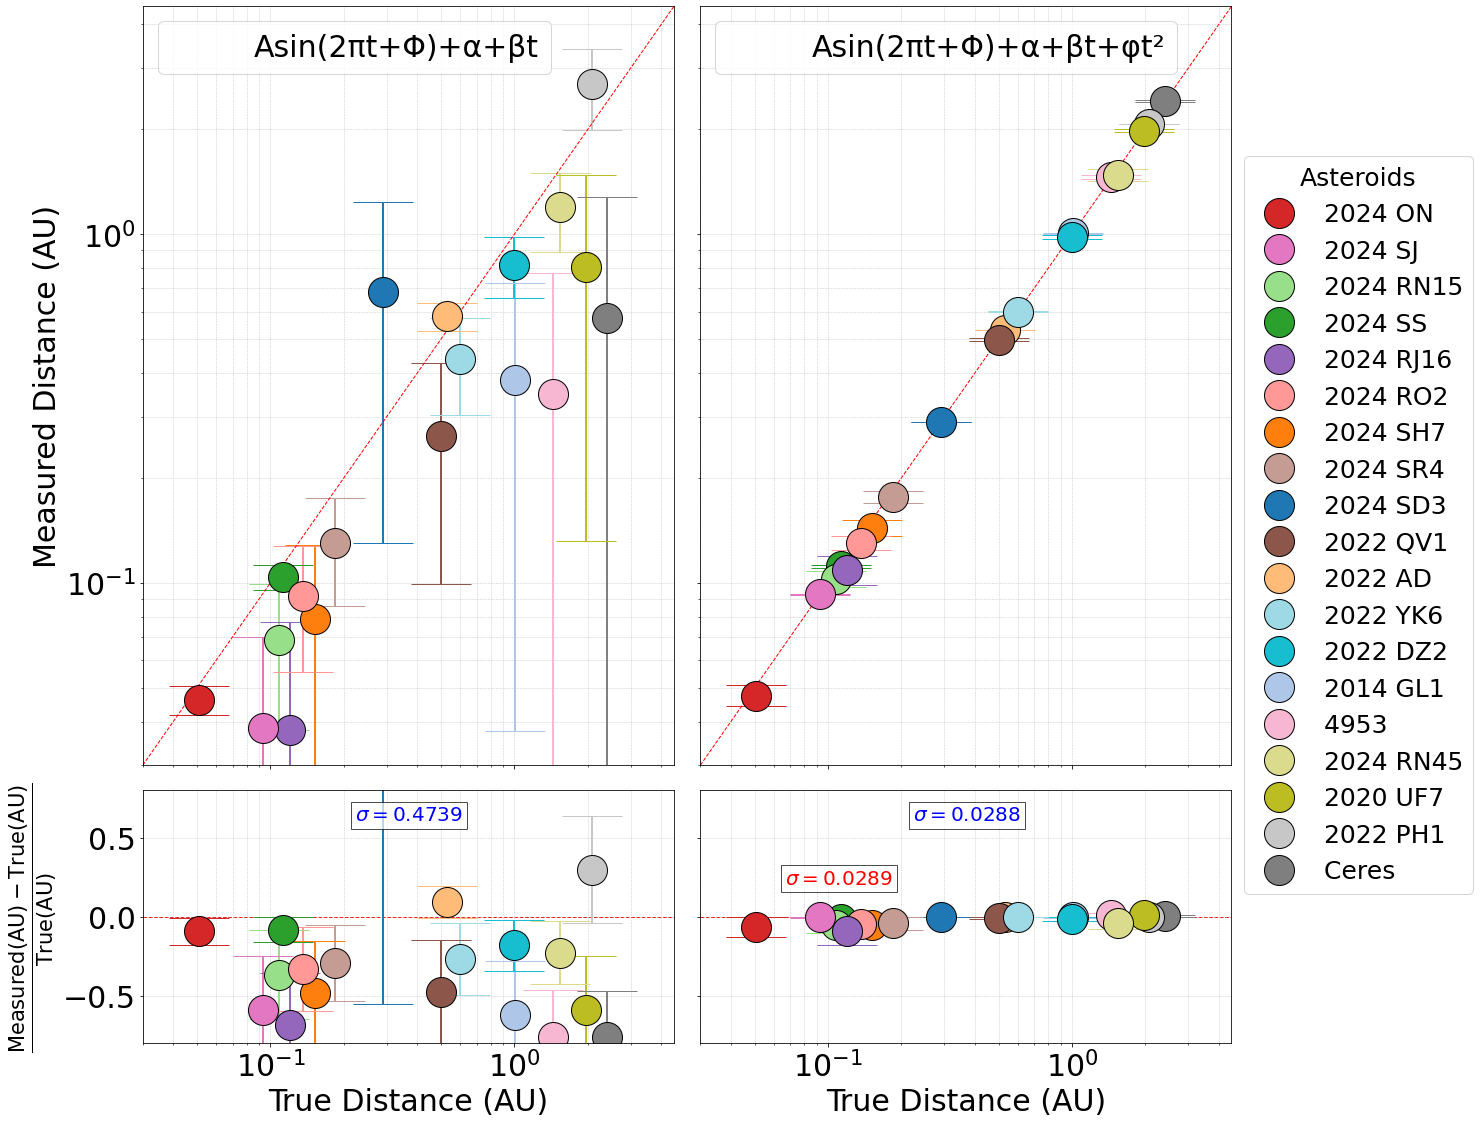

In [22]:
fig = plt.figure(figsize=(18, 18))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3, 1])
colors = plt.cm.tab20(np.linspace(0, 1, len(results_df)))

# Top-left: Linear fit
ax1 = plt.subplot(gs[0, 0])
for i, color in enumerate(colors):
    ax1.errorbar(
        true_values.iloc[i], cosine_term_lin_values.iloc[i], yerr=uncertainty_cosine_lin.iloc[i], fmt='o',
        color=color, markersize=30, markeredgecolor='black', capsize=30, linewidth=2)
ax1.plot([0.03, 4.5], [0.03, 4.5], 'r--', linewidth=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.03, 4.5)
ax1.set_ylim(0.03, 4.5)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_ylabel('Measured Distance (AU)', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xticklabels([])
ax1.legend([Line2D([0], [0], color='w', lw=0)], ['Asin(2πt+Φ)+α+βt'], loc='upper left', fontsize=30)

# Top-right: Polynomial fit
ax2 = plt.subplot(gs[0, 1])
for i, color in enumerate(colors):
    ax2.errorbar(
        true_values.iloc[i], cosine_term_poly_values.iloc[i], yerr=uncertainty_cosine_poly.iloc[i], fmt='o',
        color=color, markersize=30, markeredgecolor='black', capsize=30, linewidth=2)
ax2.plot([0.03, 4.5], [0.03, 4.5], 'r--', linewidth=1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.03, 4.5)
ax2.set_ylim(0.03, 4.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.legend([Line2D([0], [0], color='w', lw=0)], ['Asin(2πt+Φ)+α+βt+φt²'], loc='upper left', fontsize=30)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Bottom-left: Residuals for Linear fit
ax3 = plt.subplot(gs[1, 0])
for i, color in enumerate(colors):
    ax3.errorbar(
        true_values.iloc[i], residuals_lin.iloc[i], yerr=residuals_uncertainty_lin.iloc[i], fmt='o',
        color=color, markersize=30, markeredgecolor='black', capsize=30, linewidth=2)
ax3.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)
ax3.text(0.4, 0.88, f"$\\sigma = {sigma_lin:.4f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)

ax3.set_xlim(0.03, 4.5)
ax3.set_xscale('log')
ax3.set_ylim(-0.8, 0.8)
ax3.set_yscale('linear')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax3.set_ylabel(r'$\frac{\mathrm{Measured (AU)} - \mathrm{True (AU)}}{\mathrm{True (AU)}}$', fontsize=30)
ax3.set_xlabel('True Distance (AU)', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)  

# Bottom-right: Residuals for Polynomial fit
ax4 = plt.subplot(gs[1, 1])
for i, color in enumerate(colors):
    ax4.errorbar(
        true_values.iloc[i], residuals_poly.iloc[i], yerr=residuals_uncertainty_poly.iloc[i], fmt='o',
        color=color, markersize=30, markeredgecolor='black', capsize=30, linewidth=2)
ax4.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)
ax4.text(0.4, 0.88, f"$\\sigma = {sigma_poly:.4f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)
ax4.text(0.16, 0.63, f"$\\sigma= {std_dev_residuals_below_03:.4f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)

ax4.set_xlim(0.03, 4.5)
ax4.set_xscale('log')
ax4.set_ylim(-0.8, 0.8)
ax4.set_yscale('linear')
ax4.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax4.set_xlabel('True Distance (AU)', fontsize=30)
ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=30)

#-------------- Sorting Asteroid distance in legend ----------------

if isinstance(true_values, pd.Series):
    results_df['Mean Delta'] = true_values
else:
    results_df['Mean Delta'] = true_values.mean(axis=1)  

sorted_indices    = results_df['Mean Delta'].values.argsort()
sorted_file_names = results_df['File Name'].iloc[sorted_indices]
sorted_deltas     = results_df['Mean Delta'].iloc[sorted_indices] 

colors = np.array(colors)  
sorted_colors = colors[sorted_indices]

max_name_length = max(len(file_name.replace('.csv', '')) for file_name in sorted_file_names)

handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
           markeredgecolor='black', markersize=30, 
           label=f"{file_name.replace('.csv', '').ljust(max_name_length)}")  
    for file_name, delta, color in zip(sorted_file_names, sorted_deltas, sorted_colors)]

fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=25, 
           title="Asteroids", title_fontsize=25, frameon=True)

plt.subplots_adjust(left=0.01, right=0.85, top=0.9, bottom=0.1, wspace=0.05, hspace=0.05)
plt.savefig("Figure 4.png", format="png", dpi=300, bbox_inches="tight")
plt.show()
